In [26]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Dataset & Dataloader

In [27]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [28]:
bs = 64 

transform = transforms.Compose([
    transforms.Grayscale(),    
    transforms.ToTensor(),
])

train_set = datasets.ImageFolder("data/train/", transform=transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle=True, num_workers=4)

test_set = datasets.ImageFolder("data/test/", transform=transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle=True)

# Arsitektur & Config

In [29]:
from jcopdl.layers import linear_block

In [30]:
class AutoEncoder(nn.Module):
    def __init__(self, z_size):
        super().__init__()
        self.encode = nn.Sequential(
            linear_block(784, 512, batch_norm=True),
            linear_block(512, 256, batch_norm=True),
            linear_block(256, z_size, activation='sigmoid')
        )
        
        self.decode = nn.Sequential(
            linear_block(z_size, 256, batch_norm=True),
            linear_block(256, 512, batch_norm=True),
            linear_block(512, 784, activation='sigmoid')
        )                                
                        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [31]:
config = set_config ({
    "z_size": 32,
    "batch_size": bs
})

# Training Preparation -> MCOC

In [32]:
model = AutoEncoder(config.z_size).to(device)

# Load Model

In [33]:
weights = torch.load("model/ae/weights_best.pth", map_location="cpu")
model.load_state_dict(weights)
model = model.to(device);  

# Evaluate

In [36]:
feature, target = next(iter(testloader))
feature = feature.view(-1, 784).to(device)

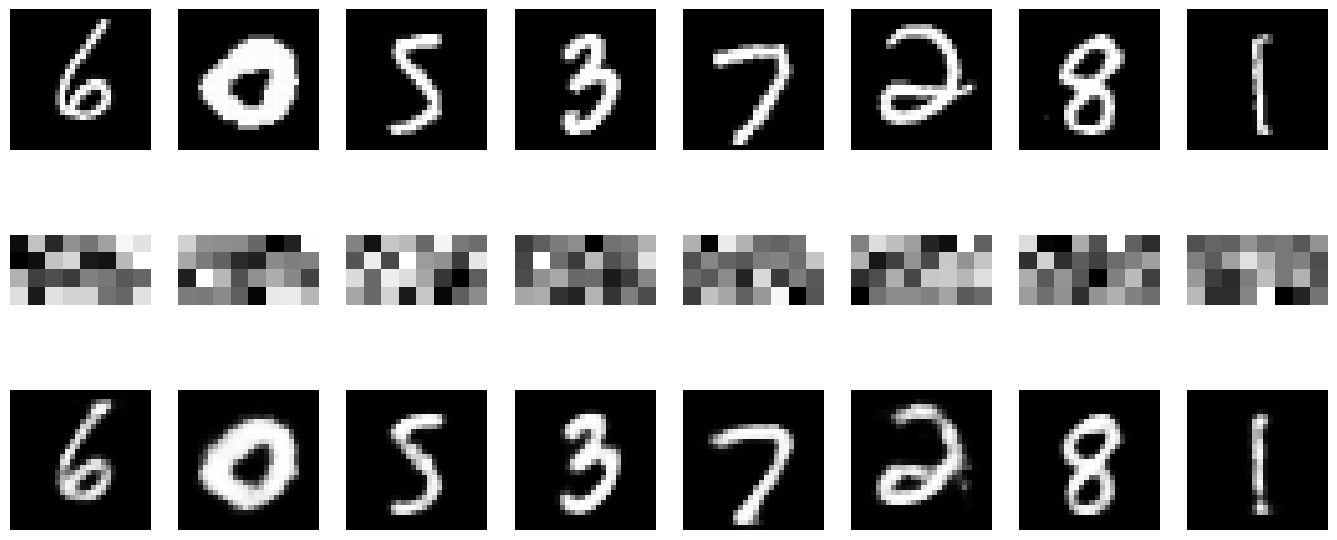

In [37]:
with torch.no_grad():
    model.eval()
    
    enc = model.encode(feature)
    dec = model.decode(enc)

fig, ax = plt.subplots(3, 8, figsize=(17, 7))

for i in range(8):
    ax[0, i].imshow(feature[i].view(28, 28).cpu(), cmap="gray")
    ax[0, i].axis("off")
    
    ax[1, i].imshow(enc[i].view(4, 8).cpu(), cmap="gray")
    ax[1, i].axis("off")
    
    ax[2, i].imshow(dec[i].view(28, 28).cpu(), cmap="gray")
    ax[2, i].axis("off")

# Playground

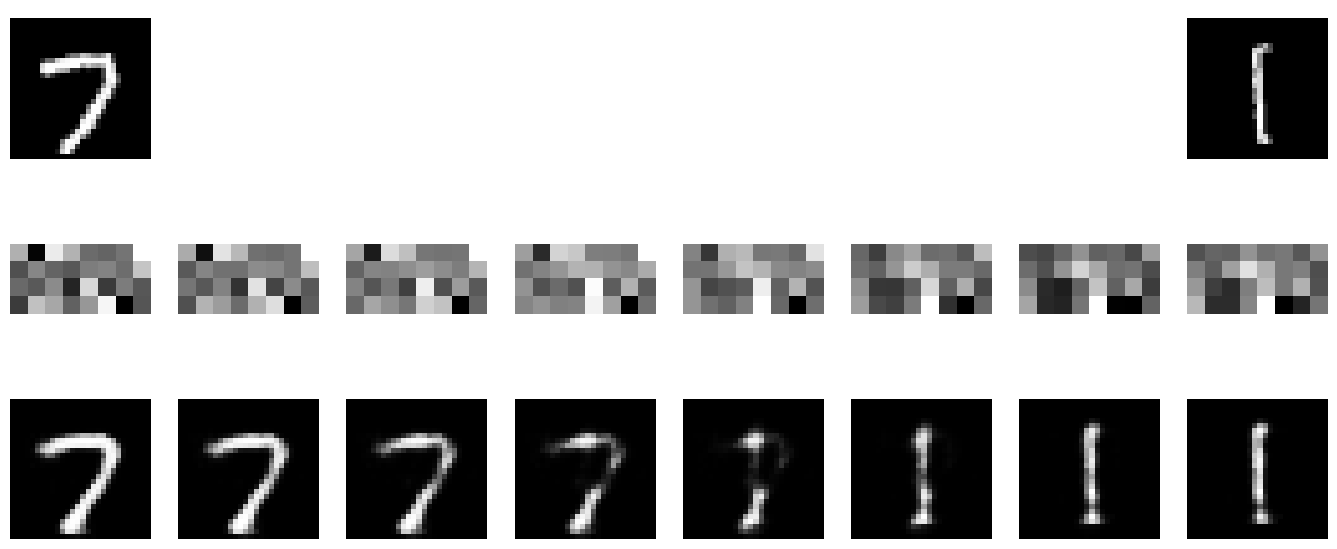

In [38]:
with torch.no_grad():
    model.eval()
    enc = model.encode(feature)
    
    code1, code2 = enc[4], enc[7]
    codes = [(1-i)*code1 + i*code2 for i in np.linspace(0, 1, 8)]
    enc = torch.stack(codes)
    
    dec = model.decode(enc)

fig, ax = plt.subplots(3, 8, figsize=(17, 7))

ax[0, 0].imshow(feature[4].view(28, 28).cpu(), cmap="gray")
ax[0, 7].imshow(feature[7].view(28, 28).cpu(), cmap="gray")

for i in range(8):
    ax[0, i].axis("off")
    
    ax[1, i].imshow(enc[i].view(4, 8).cpu(), cmap="gray")
    ax[1, i].axis("off")
    
    ax[2, i].imshow(dec[i].view(28, 28).cpu(), cmap="gray")
    ax[2, i].axis("off")